# Further improvements

This notebook performs pilot studies into possible routes for further improving the classification results obtained from the offline experiments.
This includes:
   - Calibration on 5 minutes worth of data
   - Subsampling electrodes

Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Calibrating on 5 minutes of training
   - EEGNet: new session
   - EEGNet: new subject
   - LSTM EEGNet
      - Results
- Subsampling electrodes
   - CSP + LDA
      - Same session
      - New session
      - New subject
   - EEGNet
      - Same session
      - New session
      - New subject
   - LSTM EEGNet
      - Same session
      - New session
      - New subject

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [20]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# EEGNet model
import EEGModels
from EEGModels import EEGNet

# EEGNet model with LSTM
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Calibrating on 5 minutes of training

In the data collection setup the marker stayed on the screen for one singular second and was followed by a 1.5 – 2.5 second pause after which the next signal was shown.
This totals 3.5 seconds per sample taken.
As such, in 5 minutes, or 300 seconds, 85 samples should be obtainable.
This is reduced to 75 samples in order to obtain 25 samples per class.
These 25 samples per class are then used for calibration of both the EEGNet model and the EEGNet model extension with LSTM provided by us to compare both.
Different layers are frozen to test different setups.

<hr>

### EEGNet: new session

Results for EEGNet base were:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6927 @ epoch 1473                  | 0.761 @ epoch 1472               | 0.65                                             | 0.6573                                            |
| C           | 0.8837 @ epoch 1159                  | 0.3827 @ epoch 584               | 0.7132                                           | 0.6986                                            |
| E           | 0.7674 @ epoch 782                   | 0.5884 @ epoch 1028              | 0.7068                                           | 0.7246                                            |

Result after calibration are:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.6667 @ epoch 459                   | 0.8669 @ epoch 1846              | 0.6429                                           | 0.6181                                            |
| C           | 0.8 @ epoch 39                       | 0.798 @ epoch 2486               | 0.7104                                           | 0.7387                                            |
| E           | 0.7667 @ epoch 56                    | 0.597 @ epoch 2500               | 0.7568                                           | 0.758                                             |

In [ ]:
EEGNet(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
).layers

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet: new subject

Results for EEGNet base were:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.7654 @ epoch 92                    | 0.5768 @ epoch 135               | 0.6469                                           | 0.6479                                            |
| C (Train B&E) | 0.6993 @ epoch 458                   | 0.6921 @ epoch 344               | 0.5892                                           | 0.5996                                            |
| E (Train B&C) | 0.7454 @ epoch 889                   | 0.6425 @ epoch 1196              | 0.6419                                           | 0.6262                                            |

Result after calibration are:

| **Subject**   | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|---------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B (Train C&E) | 0.6 @ epoch 193                      | 0.8591 @ epoch 194               | 0.6373                                           | 0.6373                                            |
| C (Train B&E) | 0.7667 @ epoch 304                   | 0.6773 @ epoch 2486              | 0.6233                                           | 0.6188                                            |
| E (Train B&C) | 0.7333 @ epoch 85                    | 0.6853 @ epoch 2374              | 0.6432                                           | 0.6602                                            |

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_model = EEGNet(
        nb_classes = 3, # int, number of classes to classify. 
        Chans = 21, # number of channels in the EEG data. 
        Samples = 100, # number of time points in the EEG data. (default: 128)
        dropoutRate = 0.5, # dropout fraction. (default: 0.5)
        kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
        F1 = 8, # number of temporal filters. (default: 8)
        F2 = 16, # number of pointwise filters. (default: 16)
        D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
        norm_rate = 0.25, # Normalisation rate. (default: 0.25)
        dropoutType = 'SpatialDropout2D' # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
        )

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/4/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                # Allow last conv layer to learn
                #calibration_model.layers[8].trainable = True # Overfits
                
                # Allow last layers to train (softmax)
                calibration_model.layers[14].trainable = True
                calibration_model.layers[15].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                calibration_model.layers[9].trainable = True
                
                
                # Change dropout
                calibration_model.layers[7].rate = 0
                calibration_model.layers[12].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 2500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/4/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet with LSTM conv: new session

Results before calibration were:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.6545 @ epoch 300                             | 0.8255 @ epoch 169                         | 0.6385                                                     | 0.6594                                                      |
| C           | 0.8663 @ epoch 300                             | 0.4087 @ epoch 337                         | 0.6872                                                     | 0.6632                                                      |
| E           | 0.7431 @ epoch 191                             | 0.6214 @ epoch 191                         | 0.6492                                                     | 0.6492                                                      |

Result after calibration are:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7333 @ epoch 213                             | 0.8291 @ epoch 82                          | 0.6158                                                     | 0.6395                                                      |
| C           | 0.8 @ epoch 1                                  | 0.6055 @ epoch 185                         | 0.6595                                                     | 0.6652                                                      |
| E           | 0.8 @ epoch 11                                 | 0.6687 @ epoch 457                         | 0.6727                                                     | 0.7807                                                      |

In [ ]:
####################################################
# MODEL OVERVIEW
####################################################

EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
).layers

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_convlstm_calibration_newsession_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                
                # Allow last layers to train (softmax)
                calibration_model.layers[11].trainable = True
                calibration_model.layers[12].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                
                
                # Change dropout
                calibration_model.layers[6].rate = 0
                calibration_model.layers[9].rate = 0.2
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.0001), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/samesubject_differentsession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr>

### EEGNet with LSTM conv: new subject

Results before calibration were:

| **Subject** | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|-------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B           | 0.7497 @ epoch 82                              | 0.6353 @ epoch 47                          | 0.626                                                      | 0.6125                                                      |
| C           | 0.7329 @ epoch 50                              | 0.6575 @ epoch 109                         | 0.6204                                                     | 0.5746                                                      |
| E           | 0.724 @ epoch 240                              | 0.6687 @ epoch 75                          | 0.6136                                                     | 0.6618                                                      |

Result after calibration are:

| **Subject**   | **EEGNet LSTM conv: best validation accuracy** | **EEGNet LSTM conv: best validation loss** | **EEGNet LSTM conv: test split accuracy (best acc model)** | **EEGNet LSTM conv: test split accuracy (best loss model)** |
|---------------|------------------------------------------------|--------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| B (Train C&E) | 0.6667 @ epoch 182                             | 0.8062 @ epoch 366                         | 0.6249                                                     | 0.626                                                       |
| C (Train B&E) | 0.7333 @ epoch 206                             | 0.7253 @ epoch 240                         | 0.621                                                      | 0.6199                                                      |
| E (Train B&C) | 0.8667 @ epoch 9                               | 0.3985 @ epoch 378                         | 0.6625                                                     | 0.7216                                                      |

In [ ]:
####################################################
# CALIBRATE EEGNET ON NEW SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue
do_experiment = False

keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 40, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 9, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.7,
    ltsm_l1 = 0.00005, 
    ltsm_l2 = 0.00005
)

if do_experiment:
        # Loop over all found results
        for subject_id in subject_ids_to_test:
                print()
                print("####################################################")
                print(f"# RESULTS FOR SUBJECT {subject_id}")
                print("####################################################")
                print()
                
                ################### LOAD DATA ###################
                # Names for model
                pretrained_model_name = f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
                
                tensorboard_name = f"paper-notebook8_eegnet_convlstm_calibration_newsubject_subject{subject_id}"
                best_base_model_filename =  f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
                
                # Open lowest loss model from file, lowest loss is chosen as it likely needs "least calibration"
                pretrained_model = TF_tools.load_lowest_loss_model(filepath= pretrained_model_name)
                
                # Get train and test split
                with io.capture_output():
                        # Get new session data
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
                        
                        # Get epochs for new session
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Fix the indexing
                        # NOTE: this is some weird MNE behaviour, the index retreived is not the actual index if not reset due to filtering done
                        mne_epochs.reset_drop_log_selection()
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                        
                        # Get calibration test split
                        calibration_items, test_items = CLA_dataset.get_calibration_test_split_from_epochs(epochs= mne_epochs,
                                                                                                           amount_of_samples_in_calibration_per_class = 25)
                        
                        
                # Get OHE from file
                with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
                        ohe = pickle.load(f)
                        
                        
                calibration_epochs = mne_epochs[calibration_items]
                test_epochs = mne_epochs[test_items]

                # Get labels
                y_train = calibration_epochs.events[:, -1]
                y_test = test_epochs.events[:, -1]

                # Get train and test data
                X_train = calibration_epochs.get_data(tmin= 0.1, tmax= 0.6)
                X_test = test_epochs.get_data(tmin= 0.1, tmax= 0.6)

                # Fix scaling sensitivity as MNE stores as data * 10e-6
                X_train = X_train * 1000000
                X_test = X_test * 1000000
                
                # Further devide the calibration split in train and eval samples
                X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size = 0.4, # Use 5 samples per class for validation
                                                                  shuffle= True,
                                                                  stratify= y_train,                                                    
                                                                  random_state= 1998)
                
                # Convert labels with OHE for Keras
                y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
                y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()
                y_val = ohe.transform(y_val.reshape(-1, 1)).toarray()
                
                # Print stats
                print(f"Calibrating with {np.shape(X_train)} windows")
                print(f"Testing with {np.shape(X_test)} windows")
                
                print("Calibrating epochs")
                display(calibration_epochs)
                
                print("test epochs")
                display(test_epochs)
                        
                ################### CALIBRATE MODEL ###################
                # Make a calibration model
                calibration_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)

                
                # Copy weights from pretrained model
                calibration_model.set_weights(pretrained_model.get_weights())
                
                for layer in calibration_model.layers:
                        layer.trainable = False
                
                
                # Allow last layers to train (softmax)
                calibration_model.layers[11].trainable = True
                calibration_model.layers[12].trainable = True
                
                # Allow batch norm to train due to weird behaviour
                calibration_model.layers[2].trainable = True
                calibration_model.layers[4].trainable = True
                
                
                # Change dropout
                calibration_model.layers[6].rate = 0
                calibration_model.layers[9].rate = 0.3
                
                # Compile the model so it can be fitted, note a lower learning rate is set
                calibration_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate= 0.00005), metrics=["accuracy"])
                
                # Train model with GPU as means of recalibrating
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = calibration_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # All calibration data at once
                                epochs= 500, # Very small due to direct overfit expected
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                        TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                        TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_data= (X_val, y_val),
                                shuffle= True,
                                use_multiprocessing= True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                        
                # Store the test data
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/X_test.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                        
                with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/y_test.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
        
                # remove unused vars
                del mne_raw
                del mne_epochs
                del pretrained_model_name
                del pretrained_model
                del f
                del X_test
                del y_test
                del ohe
                del calibration_epochs
                del calibration_items
                del test_epochs
                del test_items
                del X_train
                del y_train
                del X_val
                del y_val
                del tensorboard_name
                del history
                del best_base_model_filename
                del calibration_model
                del file
                del layer
        
        del subject_id
        
# Remove unsused variables
del subject_ids_to_test
del baseline
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get test data session
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id)
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the test labels
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/y_test.pickle", 'rb') as f:
            y_test = pickle.load(f)
            
        # Get the test data
        with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/X_test.pickle", 'rb') as f:
            X_test = pickle.load(f)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/newsubject/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/8/calibration/EEGNet_lstmconv1D/newsubject/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Inverse y_test to label
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id
del baseline
del end_offset
del start_offset

<hr><hr>

## Subsampling electrodes

According to Kaya et al., the authors of the used dataset, the channels of most interest are C3, Cz, C4, T3 and T4.
According to our research these are: T3, C3, Cz, C4 and T4 for primary motor cortex but also P3 and P4 for poor spatial resolution inclusion and F3, Fz and F4 for the premotor cortex.

In [13]:
mi_channel_list = ["T3", "C3", "Cz", "C4", "T4", "P3", "P4", "F3", "Fz", "F4"]

<hr>

### CSP + LDA

#### Same session

Results using all channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

Results using subsampled channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.5781 +- 0.0212                         | 0.6302                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.6232 +- 0.0118                         | 0.5833                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.5864 +- 0.0153                         | 0.5759                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Validation accuracy (CV) of 0.5781 +- 0.0212
Test accuracy for subject B: 0.6302


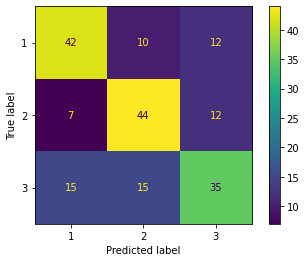

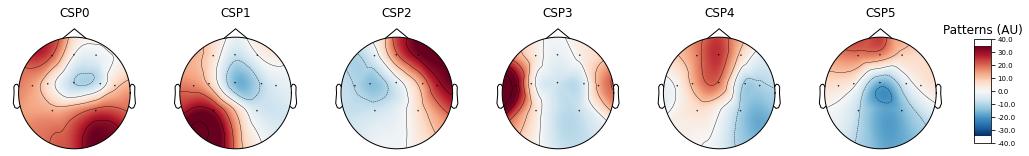




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Validation accuracy (CV) of 0.6232 +- 0.0118
Test accuracy for subject C: 0.5833


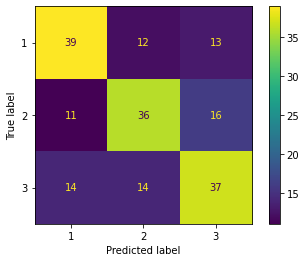

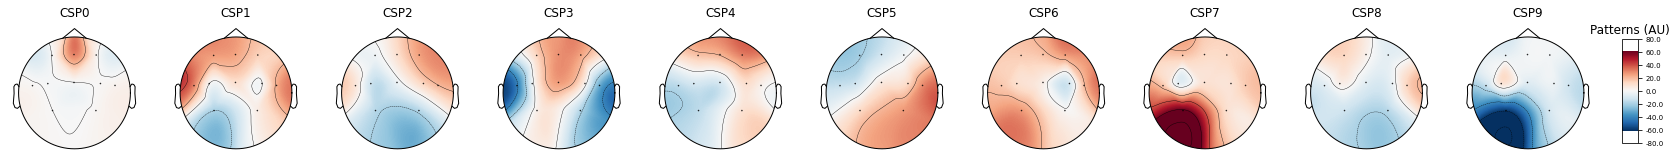




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Validation accuracy (CV) of 0.5864 +- 0.0153
Test accuracy for subject E: 0.5759


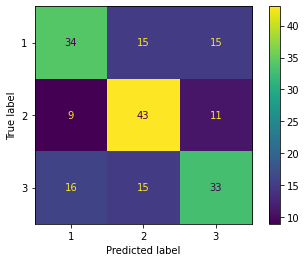

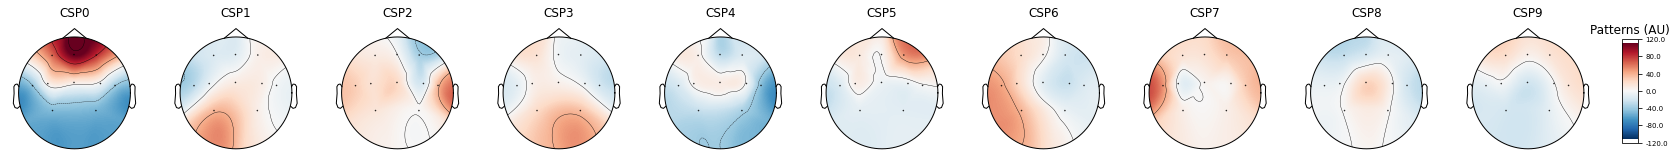

In [31]:
####################################################
# SAME SESSION TEST
####################################################

# Configure global parameters for all experiments
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this

subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [6, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ###########################################
    # DATA
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        labels = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        
    
    # Create a test and train split
    X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                        labels,
                                                        test_size = 0.2,
                                                        shuffle= True,
                                                        stratify= labels,                                                    
                                                        random_state= 1998)
    
    ###########################################
    # CLASSIFIER
    
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Get the cross val scores
    cv = StratifiedKFold(n_splits=4,
                         shuffle= True,
                         random_state= 2022)
    
    with io.capture_output():
        cv_results = cross_val_score(pipeline, X_train, y_train,
                                     cv=cv, n_jobs=-1)
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print cross val results
    print(f"Validation accuracy (CV) of {np.round(np.mean(cv_results), 4)} +- {np.round(np.std(cv_results), 4)}")
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(mne_raw.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del accuracy
del baseline
del best_found_csp_components
del best_found_solver
del best_found_tol
del csp
del cv
del cv_results
del end_offset
del filter_lower_bound
del filter_upper_bound
del i
del labels
del lda
del mne_epochs
del mne_raw
del pipeline
del start_offset
del subject_ids_to_test
del X_test
del X_train
del y_pred
del y_test
del y_train
del mne_epochs_data


#### New session

Results using all channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

Results using subsampled channels:

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.5781 +- 0.0212                         | 0.6302                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.6232 +- 0.0118                         | 0.5833                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.5864 +- 0.0153                         | 0.5759                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Validation accuracy (CV) of 0.4286 +- 0.0279
Test accuracy for subject B: 0.4302


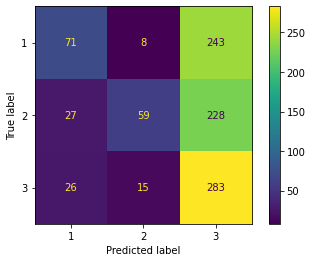

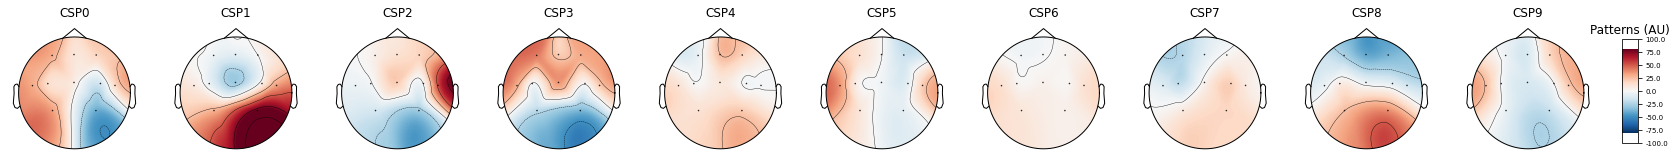




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Validation accuracy (CV) of 0.7271 +- 0.0122
Test accuracy for subject C: 0.3806


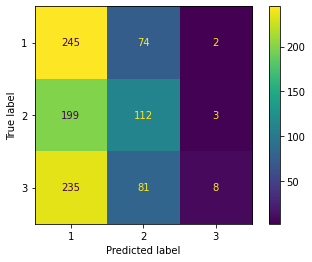

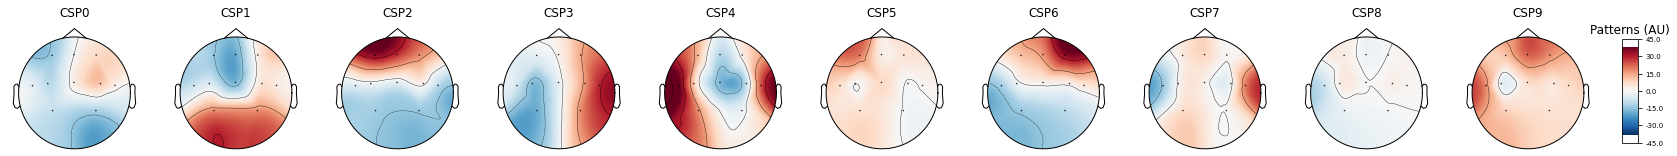




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Validation accuracy (CV) of 0.5065 +- 0.0149
Test accuracy for subject E: 0.4932


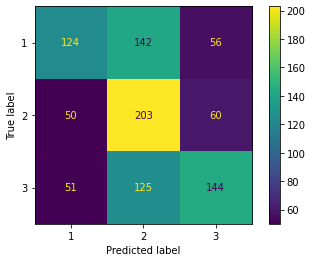

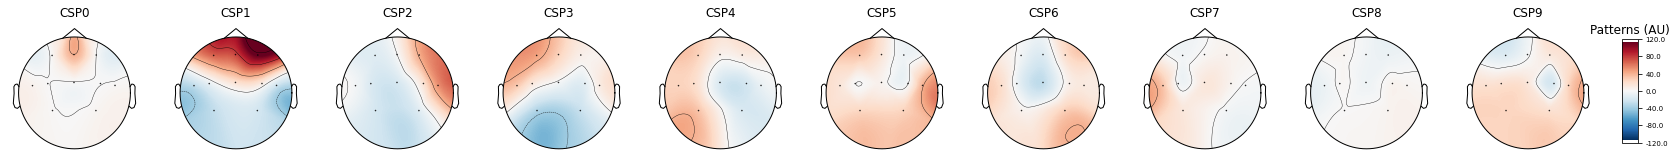

In [32]:
####################################################
# NEW SESSION TEST
####################################################

# Configure global parameters for all experiments
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this

subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ###########################################
    # TRAINING DATA
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Delete raws as they are altered
        del mne_raws
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get MNE raw object for latest recording of that subject
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Use only the channels of interst
        mne_raw = mne_raw.pick_channels(mi_channel_list)
        
        # Get epochs for that MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
        
        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)
        
        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
    
    
    ###########################################
    # CLASSIFIER
    
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Get the cross val scores
    cv = StratifiedKFold(n_splits=4,
                         shuffle= True,
                         random_state= 2022)
    
    with io.capture_output():
        cv_results = cross_val_score(pipeline, X_train, y_train,
                                     cv=cv, n_jobs=-1)
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print cross val results
    print(f"Validation accuracy (CV) of {np.round(np.mean(cv_results), 4)} +- {np.round(np.std(cv_results), 4)}")
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {np.round(accuracy, 4)}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(mne_raw.info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del accuracy
del baseline
del best_found_csp_components
del best_found_solver
del best_found_tol
del csp
del cv
del cv_results
del end_offset
del filter_lower_bound
del filter_upper_bound
del i
del lda
del mne_epochs
del mne_raw
del pipeline
del start_offset
del subject_ids_to_test
del X_test
del X_train
del y_pred
del y_test
del y_train
